In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, ChannelJitter, RandomNoise
from Network import Unet, ssim_loss, ConvolutionBlock, ASPP

path = "datasets/" + "with_labels/"
device = "cuda"

IM = torch.tensor([ 0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5,
                    0.0,  0.0,  0.1,  0.0,  0.3,  0.1,  0.0,  0.5, 0.0]).to(device)

IS = torch.tensor([0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5,
                   0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.1, 0.5, 1.0]).to(device)

df = load_df(path)
df_z = df[df["mean"] < 0.2].sample(frac=0.1)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
1,-3.59,-54.72,2016,8,1,0.60,Labeled_-3.59_-54.72_2016_08_01_0.60.npy
2,-4.01,-54.76,2021,5,1,0.63,Labeled_-4.01_-54.76_2021_05_01_0.63.npy
7,-4.25,-55.16,2019,8,1,0.39,Labeled_-4.25_-55.16_2019_08_01_0.39.npy
9,-4.31,-54.90,2017,7,1,0.56,Labeled_-4.31_-54.90_2017_07_01_0.56.npy
13,-4.23,-54.68,2017,7,1,0.66,Labeled_-4.23_-54.68_2017_07_01_0.66.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                #transforms.CenterCrop((64, 64)),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.5),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.3),
                transforms.RandomApply([RandomNoise(0.2)], p=0.3),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds) * 4, shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(1022, 256)

In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

tensor([-0.2038, -0.1820, -0.5473, -0.1278, -0.2572,  0.0432,  0.0772,  0.6424,
        -0.1913, -0.1726, -0.5482, -0.1245, -0.2838,  0.0036,  0.0554,  0.6291,
        -0.2654, -0.2520, -0.6389, -0.2112, -0.4500, -0.1403, -0.0794,  0.8119],
       device='cuda:0')
tensor([0.4201, 0.4325, 0.4353, 0.4584, 0.9747, 0.8917, 0.7453, 0.7664, 0.4617,
        0.4719, 0.4679, 0.4879, 0.9998, 0.8583, 0.7159, 0.7773, 0.2388, 0.2480,
        0.2596, 0.2729, 0.7443, 0.6335, 0.4909, 0.5838], device='cuda:0')


In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc = nn.Sequential(
            ASPP(8, 8),
        )

        self.unet = Unet(8 * 3, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss
        )

    def forward(self, x):

        # x shape is (batch, 24, 64, 64)

        # Divide the second channel in x0, x1 and x2
        x0, x1, x2 = torch.split(x, 8, dim=1)
        x0 = self.enc(x0)
        x1 = self.enc(x1)
        x2 = self.enc(x2)

        # Concatenate the three channels
        x = torch.cat([x0, x1, x2], dim=1)

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 1000000

        return x

model = Network().to(device)

In [5]:
@torch.no_grad()
def plot_images():
    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    im0 = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    im0 = im0.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im1 = (im[0][11:14] * IS[11:14, None, None]) + IM[11:14, None, None]
    im1 = im1.permute(1, 2, 0).clip(0,1).cpu().numpy()

    im2 = (im[0][19:22] * IS[19:22, None, None]) + IM[19:22, None, None]
    im2 = im2.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 5, figsize=(15, 10))
    axes[0].imshow(im0)
    axes[1].imshow(im1)
    axes[2].imshow(im2)
    axes[3].imshow(label, vmin=0, vmax=1)
    axes[4].imshow(output, vmin=0, vmax=1)
    plt.show()

In [6]:
@torch.no_grad()
def f1_score(dl):
    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?

    return float(f1), float(iou)

In [7]:
model.train()

bce_loss = nn.BCEWithLogitsLoss()
loss_fn = lambda output, target: bce_loss(output, target) + 2 * ssim_loss(torch.sigmoid(output), target)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 200
patience = 30

best_f1 = -torch.inf
best_model = model.state_dict()

val_losses = []
train_losses = []

model.train()
for i in range(epochs):

    # Train
    pbar = tqdm(train_dl)#, miniters=5)
    for data in pbar:
        optimizer.zero_grad()

        im, lb = data
        lb = lb[:, None, ...]

        out = model(im)
        loss = loss_fn(out, lb).mean()
        pbar.set_description(f"Epoch {i}. Loss: {loss:.4f}", refresh=False)
        
        loss.backward()
        optimizer.step()
    
    # Eval
    with torch.no_grad():
        model.eval()

        f1, iou = f1_score(val_dl)
        val_losses.append((f1, iou))

        if best_f1 < f1:
            best_f1 = f1
            best_model = model.state_dict()
            pat_count = 0
            print(f'{f1:.5f} *')
        else:
            print(f'{f1:.5f}')

        f1, iou = f1_score(test_dl)
        train_losses.append((f1, iou))

        pat_count = pat_count + 1
        if pat_count == patience:
            model.load_state_dict(best_model)
            print("Patience ended.")
            break

        model.train()

Epoch 0. Loss: 1.5306: 100%|██████████| 64/64 [00:04<00:00, 14.60it/s]


0.60587 *


Epoch 1. Loss: 1.2553: 100%|██████████| 64/64 [00:03<00:00, 16.83it/s]


0.69827 *


Epoch 2. Loss: 1.4575: 100%|██████████| 64/64 [00:03<00:00, 16.87it/s]


0.71138 *


Epoch 3. Loss: 1.3791: 100%|██████████| 64/64 [00:03<00:00, 16.87it/s]


0.74349 *


Epoch 4. Loss: 1.2500: 100%|██████████| 64/64 [00:03<00:00, 16.81it/s]


0.74301


Epoch 5. Loss: 1.0830: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.75482 *


Epoch 6. Loss: 1.2678: 100%|██████████| 64/64 [00:03<00:00, 17.35it/s]


0.75307


Epoch 7. Loss: 1.3125: 100%|██████████| 64/64 [00:03<00:00, 17.28it/s]


0.79165 *


Epoch 8. Loss: 1.0435: 100%|██████████| 64/64 [00:03<00:00, 17.32it/s]


0.79246 *


Epoch 9. Loss: 1.1757: 100%|██████████| 64/64 [00:03<00:00, 17.44it/s]


0.78121


Epoch 10. Loss: 1.4277: 100%|██████████| 64/64 [00:03<00:00, 17.49it/s]


0.79972 *


Epoch 11. Loss: 1.2387: 100%|██████████| 64/64 [00:03<00:00, 17.68it/s]


0.80628 *


Epoch 12. Loss: 1.1243: 100%|██████████| 64/64 [00:03<00:00, 17.52it/s]


0.79761


Epoch 13. Loss: 1.3008: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.80983 *


Epoch 14. Loss: 1.2487: 100%|██████████| 64/64 [00:03<00:00, 17.47it/s]


0.81158 *


Epoch 15. Loss: 1.0091: 100%|██████████| 64/64 [00:03<00:00, 17.84it/s]


0.81209 *


Epoch 16. Loss: 1.1097: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.82327 *


Epoch 17. Loss: 1.0791: 100%|██████████| 64/64 [00:03<00:00, 17.60it/s]


0.81935


Epoch 18. Loss: 1.1627: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.82228


Epoch 19. Loss: 1.1295: 100%|██████████| 64/64 [00:03<00:00, 17.38it/s]


0.82870 *


Epoch 20. Loss: 1.1005: 100%|██████████| 64/64 [00:03<00:00, 17.50it/s]


0.82559


Epoch 21. Loss: 1.0700: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.82855


Epoch 22. Loss: 1.0480: 100%|██████████| 64/64 [00:03<00:00, 17.71it/s]


0.83958 *


Epoch 23. Loss: 1.2131: 100%|██████████| 64/64 [00:03<00:00, 17.62it/s]


0.82457


Epoch 24. Loss: 1.2217: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.82897


Epoch 25. Loss: 1.0838: 100%|██████████| 64/64 [00:03<00:00, 17.66it/s]


0.83217


Epoch 26. Loss: 1.1736: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.83549


Epoch 27. Loss: 1.3181: 100%|██████████| 64/64 [00:03<00:00, 17.74it/s]


0.83567


Epoch 28. Loss: 1.1620: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.83094


Epoch 29. Loss: 1.0397: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.83013


Epoch 30. Loss: 0.9966: 100%|██████████| 64/64 [00:03<00:00, 17.38it/s]


0.83110


Epoch 31. Loss: 1.1070: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.83334


Epoch 32. Loss: 0.8864: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.83697


Epoch 33. Loss: 1.0330: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.83467


Epoch 34. Loss: 1.2400: 100%|██████████| 64/64 [00:03<00:00, 17.60it/s]


0.84422 *


Epoch 35. Loss: 1.0325: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.83860


Epoch 36. Loss: 1.1521: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.84482 *


Epoch 37. Loss: 1.0052: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.84493 *


Epoch 38. Loss: 0.8976: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.83938


Epoch 39. Loss: 1.1383: 100%|██████████| 64/64 [00:03<00:00, 17.68it/s]


0.84514 *


Epoch 40. Loss: 1.0928: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.84085


Epoch 41. Loss: 1.0794: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.84742 *


Epoch 42. Loss: 0.7726: 100%|██████████| 64/64 [00:03<00:00, 17.77it/s]


0.83995


Epoch 43. Loss: 1.0749: 100%|██████████| 64/64 [00:03<00:00, 17.50it/s]


0.84209


Epoch 44. Loss: 1.2370: 100%|██████████| 64/64 [00:03<00:00, 17.40it/s]


0.84336


Epoch 45. Loss: 1.1407: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.85270 *


Epoch 46. Loss: 1.0414: 100%|██████████| 64/64 [00:03<00:00, 17.69it/s]


0.83981


Epoch 47. Loss: 0.9861: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.84788


Epoch 48. Loss: 0.9007: 100%|██████████| 64/64 [00:03<00:00, 17.48it/s]


0.85642 *


Epoch 49. Loss: 1.0399: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.83372


Epoch 50. Loss: 0.9867: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.84515


Epoch 51. Loss: 1.0217: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.84978


Epoch 52. Loss: 0.9518: 100%|██████████| 64/64 [00:03<00:00, 17.66it/s]


0.84574


Epoch 53. Loss: 1.2188: 100%|██████████| 64/64 [00:03<00:00, 17.77it/s]


0.84976


Epoch 54. Loss: 1.0481: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.85007


Epoch 55. Loss: 1.0661: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.84918


Epoch 56. Loss: 1.0013: 100%|██████████| 64/64 [00:03<00:00, 17.77it/s]


0.85229


Epoch 57. Loss: 0.8768: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.84849


Epoch 58. Loss: 0.9324: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.84590


Epoch 59. Loss: 1.0813: 100%|██████████| 64/64 [00:03<00:00, 17.52it/s]


0.85037


Epoch 60. Loss: 1.1245: 100%|██████████| 64/64 [00:03<00:00, 17.41it/s]


0.84988


Epoch 61. Loss: 0.7594: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.85255


Epoch 62. Loss: 0.8674: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.85793 *


Epoch 63. Loss: 1.0230: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.84349


Epoch 64. Loss: 0.7683: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.84675


Epoch 65. Loss: 0.8648: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.85553


Epoch 66. Loss: 1.0271: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.85317


Epoch 67. Loss: 1.0602: 100%|██████████| 64/64 [00:03<00:00, 17.56it/s]


0.84292


Epoch 68. Loss: 0.9943: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.86102 *


Epoch 69. Loss: 0.8994: 100%|██████████| 64/64 [00:03<00:00, 17.26it/s]


0.84941


Epoch 70. Loss: 1.1458: 100%|██████████| 64/64 [00:03<00:00, 17.56it/s]


0.86005


Epoch 71. Loss: 0.7155: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.85207


Epoch 72. Loss: 1.2719: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.84827


Epoch 73. Loss: 0.9789: 100%|██████████| 64/64 [00:03<00:00, 17.56it/s]


0.85688


Epoch 74. Loss: 0.9354: 100%|██████████| 64/64 [00:03<00:00, 17.42it/s]


0.85172


Epoch 75. Loss: 1.1426: 100%|██████████| 64/64 [00:03<00:00, 17.71it/s]


0.83707


Epoch 76. Loss: 0.8159: 100%|██████████| 64/64 [00:03<00:00, 17.56it/s]


0.86059


Epoch 77. Loss: 0.7729: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.85316


Epoch 78. Loss: 0.9244: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.84639


Epoch 79. Loss: 0.9770: 100%|██████████| 64/64 [00:03<00:00, 17.72it/s]


0.85608


Epoch 80. Loss: 0.9301: 100%|██████████| 64/64 [00:03<00:00, 17.72it/s]


0.85003


Epoch 81. Loss: 0.7512: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.85888


Epoch 82. Loss: 1.0912: 100%|██████████| 64/64 [00:03<00:00, 17.34it/s]


0.85972


Epoch 83. Loss: 1.0773: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.85077


Epoch 84. Loss: 0.8676: 100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


0.84904


Epoch 85. Loss: 0.9998: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.86156 *


Epoch 86. Loss: 1.2995: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.85401


Epoch 87. Loss: 0.9716: 100%|██████████| 64/64 [00:03<00:00, 17.50it/s]


0.86192 *


Epoch 88. Loss: 1.0848: 100%|██████████| 64/64 [00:03<00:00, 17.75it/s]


0.85314


Epoch 89. Loss: 0.8214: 100%|██████████| 64/64 [00:03<00:00, 17.60it/s]


0.85336


Epoch 90. Loss: 0.9434: 100%|██████████| 64/64 [00:03<00:00, 17.71it/s]


0.85347


Epoch 91. Loss: 0.7938: 100%|██████████| 64/64 [00:03<00:00, 17.62it/s]


0.85352


Epoch 92. Loss: 0.8400: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.85311


Epoch 93. Loss: 0.8433: 100%|██████████| 64/64 [00:03<00:00, 17.73it/s]


0.85174


Epoch 94. Loss: 0.8167: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.86493 *


Epoch 95. Loss: 0.8680: 100%|██████████| 64/64 [00:03<00:00, 17.31it/s]


0.84621


Epoch 96. Loss: 0.9634: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.85043


Epoch 97. Loss: 0.8764: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.85683


Epoch 98. Loss: 0.8814: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.85792


Epoch 99. Loss: 0.8348: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.85785


Epoch 100. Loss: 1.0751: 100%|██████████| 64/64 [00:03<00:00, 17.75it/s]


0.85890


Epoch 101. Loss: 0.7598: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.85648


Epoch 102. Loss: 0.7797: 100%|██████████| 64/64 [00:03<00:00, 17.73it/s]


0.85914


Epoch 103. Loss: 1.2245: 100%|██████████| 64/64 [00:03<00:00, 17.63it/s]


0.85691


Epoch 104. Loss: 0.8043: 100%|██████████| 64/64 [00:03<00:00, 17.72it/s]


0.85666


Epoch 105. Loss: 0.9770: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.86017


Epoch 106. Loss: 0.8409: 100%|██████████| 64/64 [00:03<00:00, 17.78it/s]


0.85559


Epoch 107. Loss: 0.7707: 100%|██████████| 64/64 [00:03<00:00, 17.24it/s]


0.85042


Epoch 108. Loss: 1.0983: 100%|██████████| 64/64 [00:03<00:00, 17.69it/s]


0.85760


Epoch 109. Loss: 0.7260: 100%|██████████| 64/64 [00:03<00:00, 17.69it/s]


0.85901


Epoch 110. Loss: 0.7435: 100%|██████████| 64/64 [00:03<00:00, 17.62it/s]


0.85701


Epoch 111. Loss: 0.8974: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.84927


Epoch 112. Loss: 0.6217: 100%|██████████| 64/64 [00:03<00:00, 17.76it/s]


0.86544 *


Epoch 113. Loss: 0.9844: 100%|██████████| 64/64 [00:03<00:00, 17.74it/s]


0.85835


Epoch 114. Loss: 0.9446: 100%|██████████| 64/64 [00:03<00:00, 17.48it/s]


0.85647


Epoch 115. Loss: 0.8908: 100%|██████████| 64/64 [00:03<00:00, 17.80it/s]


0.84650


Epoch 116. Loss: 0.8350: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.86018


Epoch 117. Loss: 1.0161: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.86409


Epoch 118. Loss: 0.9539: 100%|██████████| 64/64 [00:03<00:00, 17.60it/s]


0.86143


Epoch 119. Loss: 0.8514: 100%|██████████| 64/64 [00:03<00:00, 17.62it/s]


0.84900


Epoch 120. Loss: 0.8603: 100%|██████████| 64/64 [00:03<00:00, 17.39it/s]


0.86356


Epoch 121. Loss: 0.6054: 100%|██████████| 64/64 [00:03<00:00, 17.82it/s]


0.85745


Epoch 122. Loss: 0.7367: 100%|██████████| 64/64 [00:03<00:00, 17.55it/s]


0.85564


Epoch 123. Loss: 0.8050: 100%|██████████| 64/64 [00:03<00:00, 17.71it/s]


0.85954


Epoch 124. Loss: 0.7307: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.85774


Epoch 125. Loss: 0.6498: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.86452


Epoch 126. Loss: 0.9093: 100%|██████████| 64/64 [00:03<00:00, 17.40it/s]


0.86376


Epoch 127. Loss: 1.1479: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.85007


Epoch 128. Loss: 0.8737: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.84845


Epoch 129. Loss: 0.7988: 100%|██████████| 64/64 [00:03<00:00, 17.68it/s]


0.85109


Epoch 130. Loss: 0.7379: 100%|██████████| 64/64 [00:03<00:00, 17.70it/s]


0.85671


Epoch 131. Loss: 0.7195: 100%|██████████| 64/64 [00:03<00:00, 17.82it/s]


0.86603 *


Epoch 132. Loss: 0.9872: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.85232


Epoch 133. Loss: 0.6564: 100%|██████████| 64/64 [00:03<00:00, 17.23it/s]


0.86394


Epoch 134. Loss: 0.7895: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.86514


Epoch 135. Loss: 0.6701: 100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


0.85252


Epoch 136. Loss: 0.7775: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.86087


Epoch 137. Loss: 0.8845: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.85091


Epoch 138. Loss: 0.9512: 100%|██████████| 64/64 [00:03<00:00, 17.43it/s]


0.87177 *


Epoch 139. Loss: 1.0105: 100%|██████████| 64/64 [00:03<00:00, 17.66it/s]


0.85776


Epoch 140. Loss: 0.9990: 100%|██████████| 64/64 [00:03<00:00, 17.72it/s]


0.86316


Epoch 141. Loss: 0.7891: 100%|██████████| 64/64 [00:03<00:00, 17.58it/s]


0.86459


Epoch 142. Loss: 0.8905: 100%|██████████| 64/64 [00:03<00:00, 17.69it/s]


0.86413


Epoch 143. Loss: 0.8728: 100%|██████████| 64/64 [00:03<00:00, 17.57it/s]


0.86412


Epoch 144. Loss: 0.8019: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.85002


Epoch 145. Loss: 0.9438: 100%|██████████| 64/64 [00:03<00:00, 17.75it/s]


0.86578


Epoch 146. Loss: 0.6811: 100%|██████████| 64/64 [00:03<00:00, 17.40it/s]


0.86095


Epoch 147. Loss: 0.8136: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.85607


Epoch 148. Loss: 0.7679: 100%|██████████| 64/64 [00:03<00:00, 17.75it/s]


0.84980


Epoch 149. Loss: 0.8561: 100%|██████████| 64/64 [00:03<00:00, 17.71it/s]


0.85792


Epoch 150. Loss: 0.8280: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.86370


Epoch 151. Loss: 0.8960: 100%|██████████| 64/64 [00:03<00:00, 17.61it/s]


0.85909


Epoch 152. Loss: 0.9597: 100%|██████████| 64/64 [00:03<00:00, 17.81it/s]


0.85383


Epoch 153. Loss: 0.7612: 100%|██████████| 64/64 [00:03<00:00, 17.62it/s]


0.85309


Epoch 154. Loss: 0.8029: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.86018


Epoch 155. Loss: 0.8928: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.86039


Epoch 156. Loss: 0.9003: 100%|██████████| 64/64 [00:03<00:00, 17.59it/s]


0.86711


Epoch 157. Loss: 0.7276: 100%|██████████| 64/64 [00:03<00:00, 17.53it/s]


0.85819


Epoch 158. Loss: 0.9186: 100%|██████████| 64/64 [00:03<00:00, 17.64it/s]


0.85803


Epoch 159. Loss: 0.8740: 100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


0.86399


Epoch 160. Loss: 0.9167: 100%|██████████| 64/64 [00:03<00:00, 17.47it/s]


0.85844


Epoch 161. Loss: 0.7950: 100%|██████████| 64/64 [00:03<00:00, 17.75it/s]


0.86265


Epoch 162. Loss: 0.8815: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.86033


Epoch 163. Loss: 0.6754: 100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


0.86181


Epoch 164. Loss: 0.6739: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.85883


Epoch 165. Loss: 0.8294: 100%|██████████| 64/64 [00:03<00:00, 17.65it/s]


0.85846


Epoch 166. Loss: 0.9564: 100%|██████████| 64/64 [00:03<00:00, 17.67it/s]


0.86150


Epoch 167. Loss: 0.7084: 100%|██████████| 64/64 [00:03<00:00, 17.73it/s]


0.85504
Patience ended.


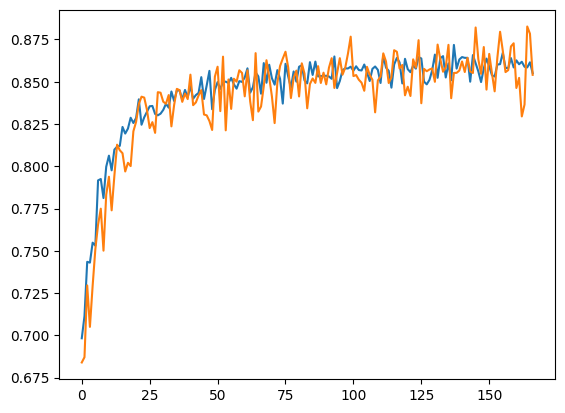

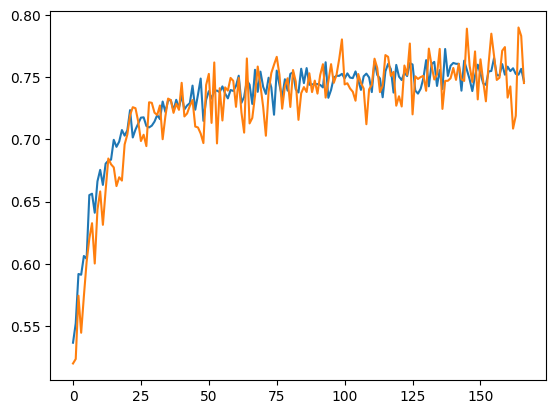

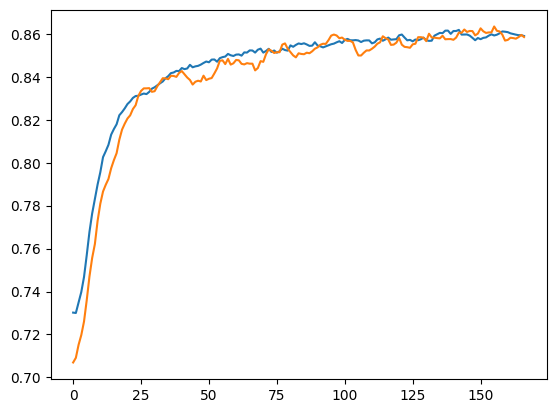

0.8589806854724884
0.871767520904541


In [35]:
from scipy.ndimage import uniform_filter1d

val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

aa = np.array(val_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)

bb = np.array(train_f1[1:])
bb = uniform_filter1d(bb, size=10)
plt.plot(bb)
plt.show()

print(aa[-1])
print(max(val_f1))

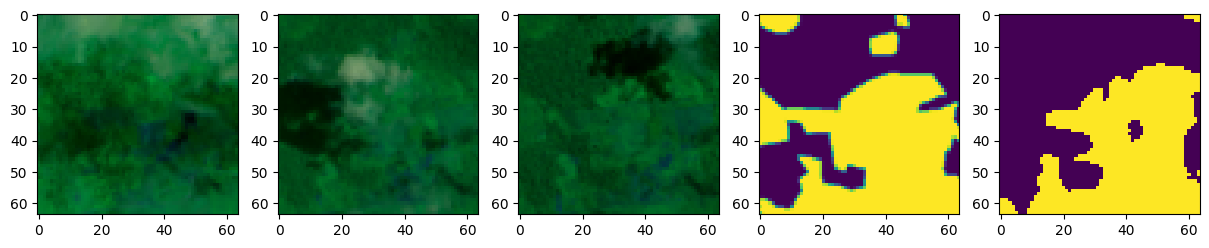

In [37]:
plot_images()